[![在 Colab 中打开](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/state-schema.ipynb) [![在 LangChain Academy 中打开](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239426-lesson-1-state-schema)


# 状态 Schema

## 回顾

在第一模块中我们打下了基础，构建了这样一个智能体：

* `act` —— 让模型调用特定工具
* `observe` —— 把工具输出传回模型
* `reason` —— 让模型推理工具输出以决定下一步动作（例如继续调用工具或直接回复）
* `persist state` —— 使用内存型 checkpointer 支持在中断下的长对话

我们还展示了如何在 LangGraph Studio 本地运行它，或通过 LangGraph Cloud 部署。

## 目标

本模块将更深入地理解状态与记忆。

首先回顾一下定义状态 schema 的几种方式。


In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph

## Schema

在定义 LangGraph 的 `StateGraph` 时，我们需要一个[状态 schema](https://langchain-ai.github.io/langgraph/concepts/low_level/#state)。

状态 schema 代表图会使用的数据结构和类型。

所有节点都应以该 schema 进行通信。

LangGraph 提供了多种方式来定义状态 schema，可搭配不同的 Python[类型](https://docs.python.org/3/library/stdtypes.html#type-objects)与校验方法！

## TypedDict

正如我们在第一模块提到的，可以使用 Python `typing` 模块中的 `TypedDict` 类。

它允许你声明键和值的类型。

不过要注意，这些只是类型提示。

它们可以被静态类型检查器（比如 [mypy](https://github.com/python/mypy)）或 IDE 使用，在代码运行前发现潜在的类型错误。

但在运行时并不会强制检查！


In [2]:
from typing_extensions import TypedDict


class TypedDictState(TypedDict):
    foo: str
    bar: str

如果想对取值做更具体的限制，可以使用 `Literal` 类型提示。

例如，`mood` 只能是 “happy” 或 “sad”。


In [3]:
from typing import Literal


class TypedDictState(TypedDict):
    name: str
    mood: Literal["happy", "sad"]

只需把我们定义的状态类（例如 `TypedDictState`）传给 `StateGraph`，就能在 LangGraph 中使用。

可以把每个状态键看作图中的一个“通道”。

正如第一模块所说，我们会在各节点中覆盖指定键（或“通道”）的值。


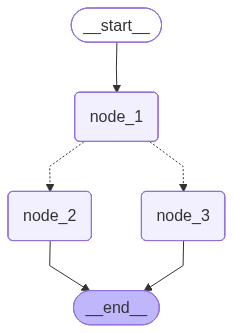

In [4]:
import random
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END


def node_1(state):
    print("---Node 1---")
    return {"name": state["name"] + " is ... "}


def node_2(state):
    print("---Node 2---")
    return {"mood": "happy"}


def node_3(state):
    print("---Node 3---")
    return {"mood": "sad"}


def decide_mood(state) -> Literal["node_2", "node_3"]:

    # Here, let's just do a 50 / 50 split between nodes 2, 3
    if random.random() < 0.5:

        # 50% of the time, we return Node 2
        return "node_2"

    # 50% of the time, we return Node 3
    return "node_3"


# Build graph
builder = StateGraph(TypedDictState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

由于状态是一个字典，我们只需要传入字典即可为状态中的 `name` 键设置初始值。


In [5]:
graph.invoke({"name": "Lance"})

---Node 1---
---Node 2---


{'name': 'Lance is ... ', 'mood': 'happy'}

## Dataclass

Python 的 [dataclasses](https://docs.python.org/3/library/dataclasses.html) 提供了[另一种定义结构化数据的方式](https://www.datacamp.com/tutorial/python-data-classes)。

它提供简洁的语法来创建主要用于存储数据的类。


In [6]:
from dataclasses import dataclass


@dataclass
class DataclassState:
    name: str
    mood: Literal["happy", "sad"]

要访问 `dataclass` 中的键，我们只需调整在 `node_1` 中的索引方式：

* 对于 `dataclass` 状态，使用 `state.name`；对于上面的 `TypedDict`，使用 `state["name"]`

你可能会觉得有点奇怪：每个节点里我们依然返回一个字典来更新状态。

这是因为 LangGraph 会分别存储状态对象中的每个键。

节点返回的对象只需要包含与状态中相匹配的键（或属性）即可！

在这个例子中，`dataclass` 只有键 `name`，所以我们依然可以通过节点返回一个字典来更新它，就像状态是 `TypedDict` 时一样。


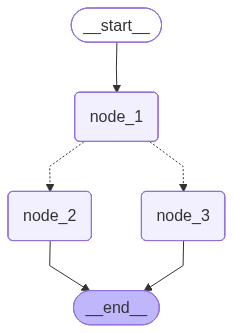

In [7]:
def node_1(state):
    print("---Node 1---")
    return {"name": state.name + " is ... "}


# Build graph
builder = StateGraph(DataclassState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

我们用 `dataclass` 来为状态中的每个键 / 通道设置初始值！


In [8]:
graph.invoke(DataclassState(name="Lance", mood="sad"))

---Node 1---
---Node 3---


{'name': 'Lance is ... ', 'mood': 'sad'}

## Pydantic

如前所述，`TypedDict` 和 `dataclass` 只提供类型提示，运行时并不会强制检查。

这意味着即便类型提示写了 `mood: list[Literal["happy","sad"]]`，你仍然可以把 `mood` 设为 `mad` 而不会报错！


In [9]:
dataclass_instance = DataclassState(name="Lance", mood="mad")

[Pydantic](https://docs.pydantic.dev/latest/api/base_model/) 是一个基于 Python 类型注解的数据验证与配置管理库。

得益于其验证能力，它[非常适合用来定义 LangGraph 的状态 schema](https://langchain-ai.github.io/langgraph/how-tos/state-model/)。

Pydantic 可以在运行时检查数据是否符合指定类型和约束。


In [10]:
from pydantic import BaseModel, field_validator, ValidationError


class PydanticState(BaseModel):
    name: str
    mood: str  # "happy" or "sad"

    @field_validator("mood")
    @classmethod
    def validate_mood(cls, value):
        # Ensure the mood is either "happy" or "sad"
        if value not in ["happy", "sad"]:
            raise ValueError("Each mood must be either 'happy' or 'sad'")
        return value


try:
    state = PydanticState(name="John Doe", mood="mad")
except ValidationError as e:
    print("Validation Error:", e)

Validation Error: 1 validation error for PydanticState
mood
  Value error, Each mood must be either 'happy' or 'sad' [type=value_error, input_value='mad', input_type=str]
    For further information visit https://errors.pydantic.dev/2.11/v/value_error


我们可以无缝地在图中使用 `PydanticState`。


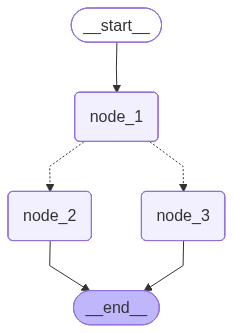

In [11]:
# Build graph
builder = StateGraph(PydanticState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [12]:
graph.invoke(PydanticState(name="Lance", mood="sad"))

---Node 1---
---Node 3---


{'name': 'Lance is ... ', 'mood': 'sad'}

In [13]:
graph.invoke({"name": "Lance", "mood": "ssss"})

ValidationError: 1 validation error for PydanticState
mood
  Value error, Each mood must be either 'happy' or 'sad' [type=value_error, input_value='ssss', input_type=str]
    For further information visit https://errors.pydantic.dev/2.11/v/value_error